In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras, compat, distribute
from tensorflow.keras import layers

from keras.datasets import fashion_mnist

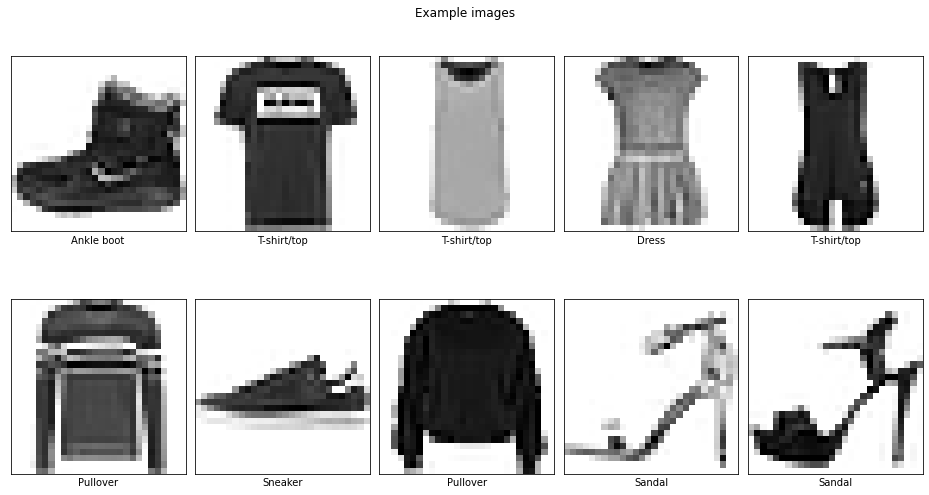

In [11]:
# Load dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_val_X, train_val_y), (test_X, test_y) = fashion_mnist.load_data()

fig, axes = plt.subplots(2, 5, constrained_layout=True)

fig.suptitle('Example images')
fig.set_size_inches([12.8, 7])

for ax, x, y in zip(axes.flatten(), train_val_X, train_val_y):
    ax.imshow(x, cmap='gray_r')

    ax.set_xlabel(class_names[y])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [12]:
# Prepare the data and splitter
n_classes = len(class_names)

train_val_size = train_val_X.shape[0]

val_size = 10000
train_size = train_val_size - val_size
test_size = test_X.shape[0]

train_val_X = train_val_X.astype('float32') / 255
test_X = test_X.astype('float32') / 255

train_val_y = keras.utils.to_categorical(train_val_y, num_classes=n_classes)
test_y = keras.utils.to_categorical(test_y, num_classes=n_classes)


pd.DataFrame([train_size, val_size, test_size], columns=['Number of samples'],
             index=['train', 'validation', 'test'])

,Number of samples
train,50000
validation,10000
test,10000


In [13]:
# Define models
models = list()

models.append(
    keras.Sequential(name='vanilla', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(784, activation='relu'),
        layers.Dense(397, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
)

models.append(
    keras.Sequential(name='dropout_0.2', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(784, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(397, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
)

models.append(
    keras.Sequential(name='batch_norm', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(784, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(397, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(10, activation='softmax')
    ])
)

models.append(
    keras.Sequential(name='batch_norm_dropout_0.2', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(784, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        layers.Dense(397, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
)

models.append(
    keras.Sequential(name='batch_norm_dropout_0.5', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(784, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(397, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
)

models.append(
    keras.Sequential(name='batch_norm_bigger_dropout_0.5', layers=[
        layers.Flatten(input_shape=train_val_X.shape[1:]),
        layers.Dense(1568, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(756, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
)

for m in models:
    m.compile(optimizer='adam', loss="categorical_crossentropy",
                    metrics=['accuracy'])

    m.summary()
    print()

Model: "vanilla"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_19 (Dense)             (None, 397)               311645    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                3980      
Total params: 931,065
Trainable params: 931,065
Non-trainable params: 0
_________________________________________________________________

Model: "dropout_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_______________________________

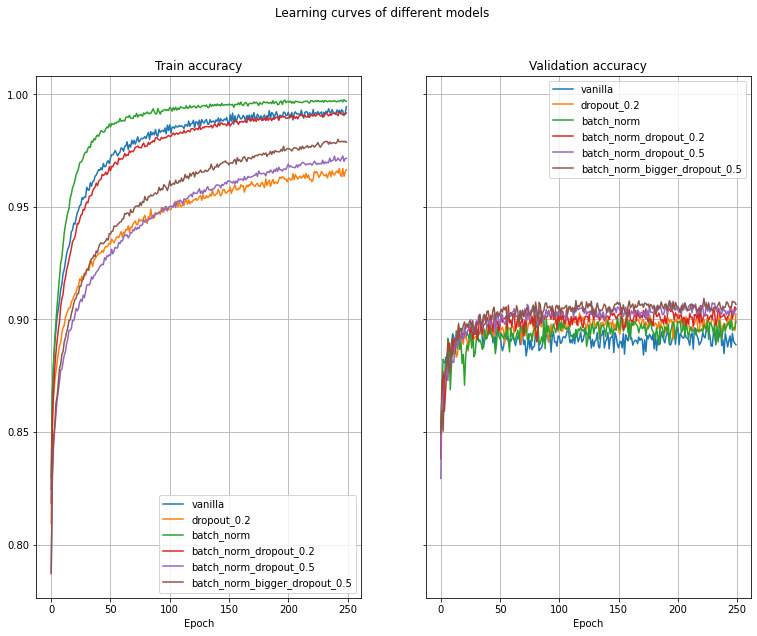

In [14]:
# Train models and plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches([12.8, 9.6])

for m in models:
    hist = m.fit(
        x=train_val_X,
        y=train_val_y,
        batch_size=30,
        epochs=250,
        verbose=0,
        validation_split=val_size/train_val_size
    )

    ax1.plot(hist.history['accuracy'], label=m.name)
    ax2.plot(hist.history['val_accuracy'], label=m.name)

fig.suptitle('Learning curves of different models')

ax1.set_title('Train accuracy')
ax2.set_title('Validation accuracy')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')

ax1.grid()
ax2.grid()

ax1.legend()
ax2.legend()

plt.show()

Test accuracy: 0.8991000056266785


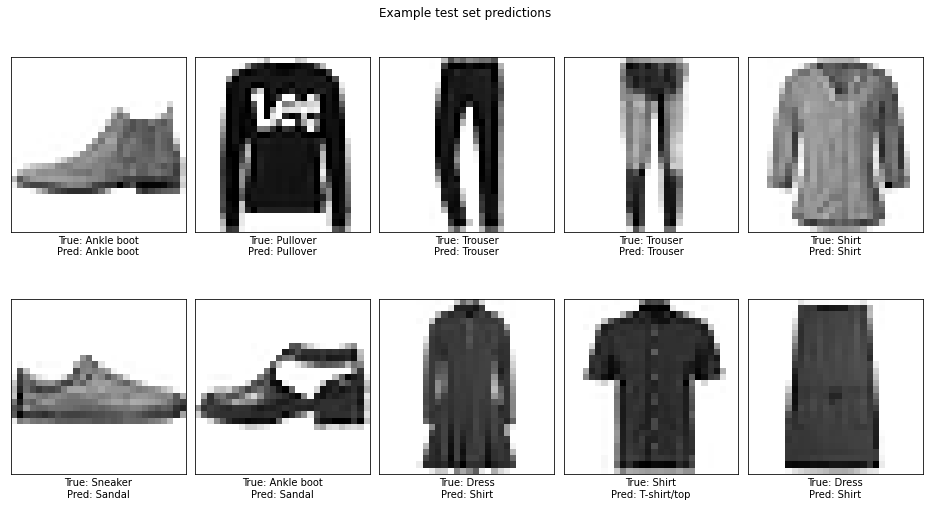

In [15]:
# Evaluate performance on the test set
chosen_model = models[5]
print('Test accuracy:', chosen_model.evaluate(test_X, test_y, verbose=0)[1])

y_true = np.argmax(test_y, axis=1)
y_pred = np.argmax(chosen_model.predict(test_X), axis=1)
errors = y_true != y_pred

fig, axes = plt.subplots(2, 5, constrained_layout=True)
fig.set_size_inches([12.8, 7])

fig.suptitle('Example test set predictions')

def plot_predictions(axes, X, y_true, y_pred):
    for ax, im, y_t, y_p in zip(axes, X, y_true, y_pred):
        ax.imshow(im, cmap='gray_r')
                
        ax.set_xlabel('True: {}\nPred: {}'
                        .format(class_names[int(y_t)], 
                                class_names[int(y_p)]))

        ax.set_xticks([])
        ax.set_yticks([])
                      
plot_predictions(axes[0], test_X[~errors], y_true[~errors], y_pred[~errors])
plot_predictions(axes[1], test_X[errors], y_true[errors], y_pred[errors])

plt.show()